##Model assessment

Connect to Google Drive, load libraries, reference

In [ ]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/MyDrive/CSC8635/

## set up the libraries that are needed to run the analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import itertools
import re, time
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
#print("Number of accelerators: ", strategy.num_replicas_in_sync)

#Based on code: https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive/CSC8635
Tensorflow version 2.7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Load data

In [ ]:
#@title
#This block of code is based on section from: https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data
#set up for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 samples frames , each one will be a different experiment
Segment_Size = 400

# Activity types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
  Csv = glob(j + '/*' )
  for i in Csv:
    df = pd.read_csv(i)
    df['Activity'] = activity_codes[j[40:43]]
    df['Sub_Num'] = i[len(j)+5:-4]
    df['Exp_num'] = 1
    ExpNum = np.zeros((df.shape[0])) 
    for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
      ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
    df['Exp_num'] = ExpNum
    #Df_all = pd.concat([Df_all,df])
    Df_all_list.append(df)
    Exp += 1        
Df_all = pd.concat(Df_all_list,axis=0)  
print(f'The data has been loaded.')
print(f'The dimensions of the complete dataset are {Df_all.shape}.')
print(f'The 16 column headers are {Df_all.columns}.')

The data has been loaded.
The dimensions of the complete dataset are (1412865, 16).
The 16 column headers are Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object').


Set up variables and response variables (X and Y), response variable is activity type, apply feature engineering (see reference)

In [ ]:
#@title
#Features based on code within: https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data
#  Calculate features
df_sum = Df_all.groupby('Exp_num', axis=0).mean().reset_index()
df_sum.columns = df_sum.columns.str.replace('.','_sum_')

df_sum_SS = np.power(Df_all.astype(float),2).groupby('Exp_num', axis=0).median().reset_index() 
df_sum_SS.columns = df_sum_SS.columns.str.replace('.','_sumSS_')

df_max = Df_all.groupby('Exp_num', axis=0).max().reset_index()
df_max.columns = df_max.columns.str.replace('.','_max_')

df_min = Df_all.groupby('Exp_num', axis=0).min().reset_index()
df_min.columns = df_min.columns.str.replace('.','_min_')

df_skew = Df_all.groupby('Exp_num', axis=0).skew().reset_index()
df_skew.columns = df_skew.columns.str.replace('.','_skew_')

df_std = Df_all.groupby('Exp_num', axis=0).std().reset_index()
df_std.columns = df_std.columns.str.replace('.','_std_')

Df_Features = pd.concat([ df_max , df_sum[df_sum.columns[2:-2]], 
                         df_min[df_min.columns[2:-2]], df_sum_SS[df_sum_SS.columns[2:-2]], 
                         df_std[df_std.columns[2:-2]], df_skew[df_skew.columns[2:-2]]], axis=1)

X = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Df_Features['Activity']
#print('Shape of X:', X.shape)
#print('Shape of Y:', Y.shape)

Train classifier model

In [ ]:
#@title
#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

Train model on scaled data

In [ ]:
#@title
# One-hot encoding
Y = to_categorical(Y)
print(Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

(3359, 7)


Evaluate model

###**Trial Participant**

In [ ]:
#@title
# Let target label become subjects
Y1 = Df_Features['Sub_Num']


Set model parameters

In [ ]:
#@title
#### Construct neural Architeture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

Train and test model

In [ ]:
#@title
# One-hot encoding

y1 = to_categorical(Y1)
print(Y1.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, y1, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])
t0=time()
### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print('Neural Network Model (keras) accuracy:', score[1])
print('Multi Layer Perceptron: total_time: {:.2f} sec'.format(time()-t0))

(3359,)
32/32 [==============================] - 0s 1ms/step - loss: 0.0504 - categorical_accuracy: 0.8651
Neural Network Model (keras) accuracy: 0.8650793433189392
Multi Layer Perceptron: total_time: 0.11 sec


Compare with other models

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y1, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.76, f1 score: 0.76, total_time: 0.83 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.76, f1 score: 0.76, total_time: 0.80 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.76, f1 score: 0.76, total_time: 0.81 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#@title
t0=time()
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro'), time()-t0))


Random Forest - accuracy: 0.95, f1 score: 0.95, total_time: 85.70 sec


In [ ]:
t0=time()
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
print('LinearSVM - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'), time()-t0))


LinearSVM - accuracy: 0.25, f1 score: 0.21, total_time: 0.94 sec


In [ ]:
t0=time()
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'), time()-t0))


rbf_SVM - accuracy: 0.63, f1: 0.63, total_time: 1.22 sec


In [ ]:
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.77, f1 score: 0.77, total_time: 1.13 sec


In [ ]:
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.75, f1 score: 0.75, total_time: 0.27 sec


Model performance = predicting trial participant

In [ ]:
#@title
print('LinearSVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro')))
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro')))
print('Logistic_regression (L1) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro')))
print('Logistic_regression (L2) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L2.predict(X_test),average ='macro')))
print('Decision tree - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro')))
print('Random Forest - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro')))
print('K- Nearest Neighbour - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro')))


LinearSVM - accuracy: 0.25, f1: 0.21
rbf_SVM - accuracy: 0.63, f1: 0.63
Logistic_regression (L1) - accuracy: 0.76, f1: 0.76
Logistic_regression (L2) - accuracy: 0.76, f1: 0.76
Decision tree - accuracy: 0.77, f1: 0.77
Random Forest - accuracy: 0.95, f1: 0.95
K- Nearest Neighbour - accuracy: 0.75, f1: 0.75


Decision tree accuracy: 0.753968253968254


<Figure size 432x288 with 0 Axes>

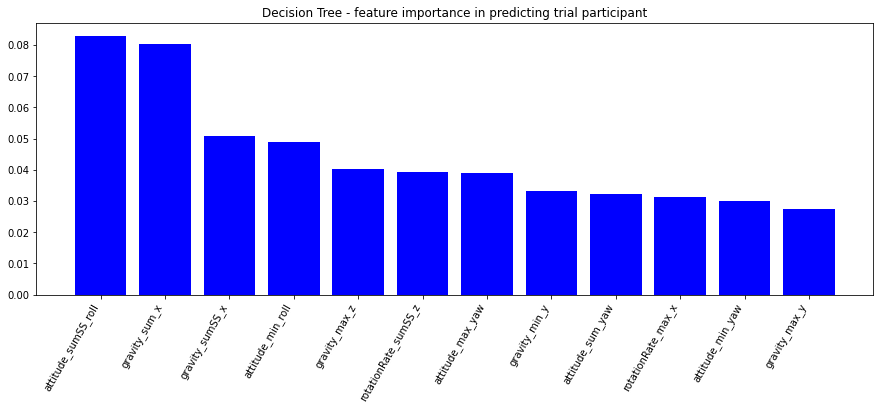

In [ ]:
#@title
feature_names = X.columns
X_names = feature_names

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)

# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=10):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="b", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
plot_keyFeat_trees(DT, X_names, 'Decision Tree - feature importance in predicting trial participant', top_features=12)

Random Forest accuracy: 0.9513888888888888


<Figure size 432x288 with 0 Axes>

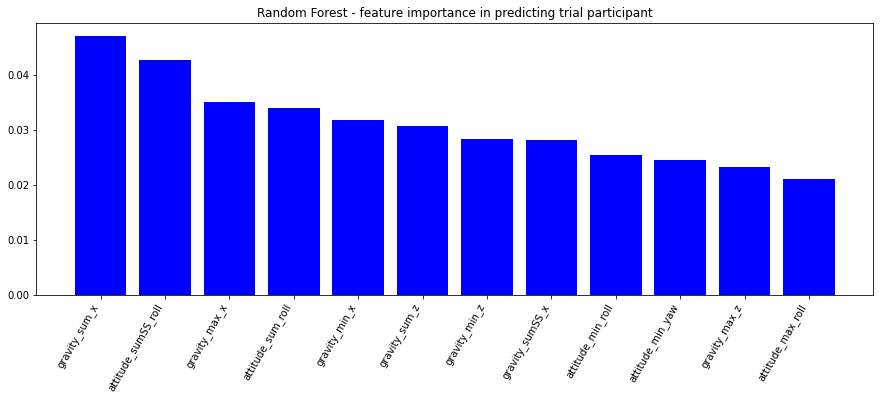

In [ ]:
#@title
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - feature importance in predicting trial participant', top_features=12)

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Trail Participant - Random Forest Confusion Matrix")
    else:
        print('Trial Participant - Random Forest Confusion Matrix')
    print(cm)

cnf_matrix = confusion_matrix(Y_test, RF.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Trial Participant - Random Forest Confusion Matrix')

Trial Participant - Random Forest Confusion Matrix
[[50  0  0  1  0  0  0  0  0  2  0  1  0  0  0  1  0  0  1  0  1  1  0  0]
 [ 0 42  0  0  0  0  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 31  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  3  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  0  0  0  0  0  2  0  1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1 39  0  0  0  0  0  0  2  0  1  0  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  2  0  0  0  0 42  0  0  0

####**Trial participant and activity type**

In [ ]:
#@title
for i in range(1,7):
    df = Df_Features[Df_Features['Activity']==i]
    x = df.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
    y = df['Sub_Num']
    y = to_categorical(y)
    
    #### Construct Neural Architecture
    input_dim = x.shape[1]
    input_img = Input(shape=(input_dim,))
    d = Dense(50, activation='relu')(input_img)
    d = Dense(20, activation='relu')(d)
    output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
    model = Model(input_img,output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['categorical_accuracy'])
    
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    history = model.fit(X_train, Y_train,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=0,
                    validation_data=[X_test,Y_test])
    
    ### Overall test accuracy
    score = model.evaluate(X_test, Y_test)
    print('Activity type:', activity_types[i-1])
    print('Neural Network Model (keras) accuracy:', score[1])

3/3 [==============================] - 0s 5ms/step - loss: 0.0773 - categorical_accuracy: 0.7640
Activity type: dws
Neural Network Model (keras) accuracy: 0.7640449404716492
3/3 [==============================] - 0s 5ms/step - loss: 0.0332 - categorical_accuracy: 0.9681
Activity type: jog
Neural Network Model (keras) accuracy: 0.9680851101875305
8/8 [==============================] - 0s 2ms/step - loss: 0.0268 - categorical_accuracy: 0.9312
Activity type: sit
Neural Network Model (keras) accuracy: 0.931174099445343
7/7 [==============================] - 0s 3ms/step - loss: 0.0981 - categorical_accuracy: 0.6741
Activity type: std
Neural Network Model (keras) accuracy: 0.6741071343421936
4/4 [==============================] - 0s 4ms/step - loss: 0.0415 - categorical_accuracy: 0.8889
Activity type: ups
Neural Network Model (keras) accuracy: 0.8888888955116272
8/8 [==============================] - 0s 2ms/step - loss: 0.0178 - categorical_accuracy: 0.9598
Activity type: wlk
Neural Network 

###**Gender**

Mapping for gender (1 for male, 0 for female)

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':1,
    '22':1,
    '23':0,
    '24':0

}

In [ ]:
#@title
# Create gender labels
Y2 = [mapping[i] for i in Df_Features['Sub_Num']]

Train model

In [ ]:
#@title
y2 = to_categorical(Y2)

X_train, X_test, Y_train, Y_test = train_test_split(X, y2, test_size=0.3, random_state=0)
#print('The number of training samples:',X_train.shape[0])
#print('The number of test samples:',X_test.shape[0])

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Construct neural Architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
t0=time()
score = model.evaluate(X_test, Y_test)
print('Neural Network (keras) accuracy:', score[1])
print('Multi Layer Perception total_time: {:.2f} sec'.format(time()-t0))

32/32 [==============================] - 0s 1ms/step - loss: 0.5555 - categorical_accuracy: 0.9216
Neural Network (keras) accuracy: 0.9216269850730896
Multi Layer Perception total_time: 0.11 sec


Prepare training and test data sets, apply scaling

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Compare with other models - train and test

Show results of model performance by gender identification

In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.79, f1 score: 0.79, total_time: 0.11 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.79, f1 score: 0.79, total_time: 0.13 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
print('LinearSVM - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'), time()-t0))


LinearSVM - accuracy: 0.70, f1 score: 0.70, total_time: 0.53 sec


In [ ]:
t0=time()
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'), time()-t0))


rbf_SVM - accuracy: 0.75, f1: 0.74, total_time: 0.76 sec


In [ ]:
#need to change to Random Forest
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.93, f1 score: 0.93, total_time: 0.27 sec


In [ ]:
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.90, f1 score: 0.90, total_time: 0.26 sec


In [ ]:
#@title
t0=time()
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro'), time()-t0))

Random Forest - accuracy: 0.97, f1 score: 0.97, total_time: 33.36 sec


In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Gender - Random Forest Confusion Matrix")
    else:
        print('Gender - Random Forest Confusion Matrix')

    print(cm)

cnf_matrix = confusion_matrix(Y_test, RF.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Gender - Random Forest Confusion Matrix')

Gender - Random Forest Confusion Matrix
[[411  11]
 [ 20 566]]


Random Forest accuracy: 0.9672619047619048


<Figure size 432x288 with 0 Axes>

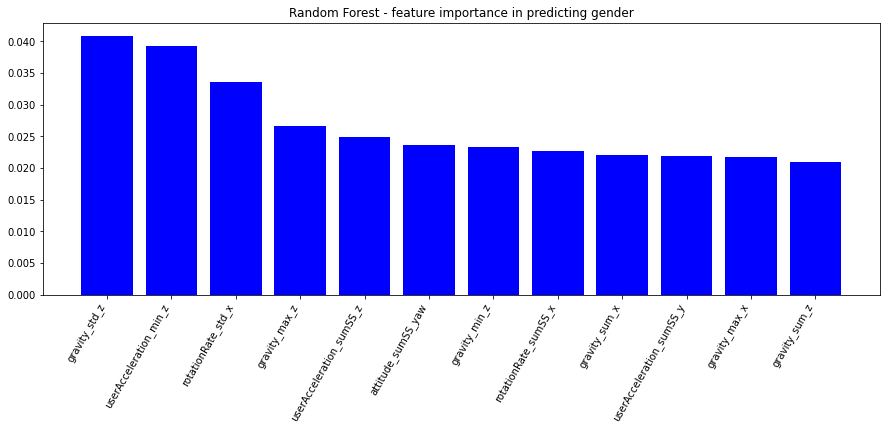

In [ ]:
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - feature importance in predicting gender', top_features=12)

###**Weight**

Mapping - above the average weight 72.125kg are labeled as 1; 0 for below average.

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':0,
    '12':0,
    '13':0,
    '14':0,
    '15':0,
    '16':1,
    '17':1,
    '18':0,
    '19':1,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':1

}

In [ ]:
#@title
# Create weight labels
Y3 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
#@title
y3 = to_categorical(Y3)

X_train, X_test, Y_train, Y_test = train_test_split(X, y3, test_size=0.3, random_state=0)
#print('The number of training samples:',X_train.shape[0])
#print('The number of test samples:',X_test.shape[0])

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])
t0=time()
### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print('Neural Network (keras) accuracy:', score[1])
print('Multi Layer Perception total_time: {:.2f} sec'.format(time()-t0))

32/32 [==============================] - 0s 1ms/step - loss: 0.7109 - categorical_accuracy: 0.8829
Neural Network (keras) accuracy: 0.8829365372657776
Multi Layer Perception total_time: 0.11 sec


In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y3, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Evaluate model performance

In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.73, f1 score: 0.71, total_time: 0.10 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.74, f1 score: 0.71, total_time: 0.11 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
print('LinearSVM - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'), time()-t0))


LinearSVM - accuracy: 0.61, f1 score: 0.47, total_time: 0.55 sec


In [ ]:
t0=time()
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'), time()-t0))


rbf_SVM - accuracy: 0.70, f1: 0.66, total_time: 0.85 sec


In [ ]:
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.87, f1 score: 0.87, total_time: 0.29 sec


In [ ]:
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.88, f1 score: 0.88, total_time: 0.36 sec


In [ ]:
#@title
t0=time()
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro'), time()-t0))

Random Forest - accuracy: 0.96, f1 score: 0.96, total_time: 27.13 sec


In [ ]:
#@title
print('LinearSVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro')))
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro')))
print('Logistic_regression (L1) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro')))
print('Logistic_regression (L2) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L2.predict(X_test),average ='macro')))
print('Decision tree - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro')))
print('Random Forest - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro')))
print('K- Nearest Neighbour - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro')))


LinearSVM - accuracy: 0.61, f1: 0.47
rbf_SVM - accuracy: 0.70, f1: 0.66
Logistic_regression (L1) - accuracy: 0.73, f1: 0.71
Logistic_regression (L2) - accuracy: 0.74, f1: 0.72
Decision tree - accuracy: 0.88, f1: 0.88
Random Forest - accuracy: 0.96, f1: 0.96
K- Nearest Neighbour - accuracy: 0.87, f1: 0.87


In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Weight - Random Forest Confusion Matrix")
    else:
        print('Weight - Random Forest Confusion Matrix')

    print(cm)

cnf_matrix = confusion_matrix(Y_test, RF.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Weight - Random Forest Confusion Matrix')

Weight - Random Forest Confusion Matrix
[[566   9]
 [ 31 402]]


Random Forest accuracy: 0.9632936507936508


<Figure size 432x288 with 0 Axes>

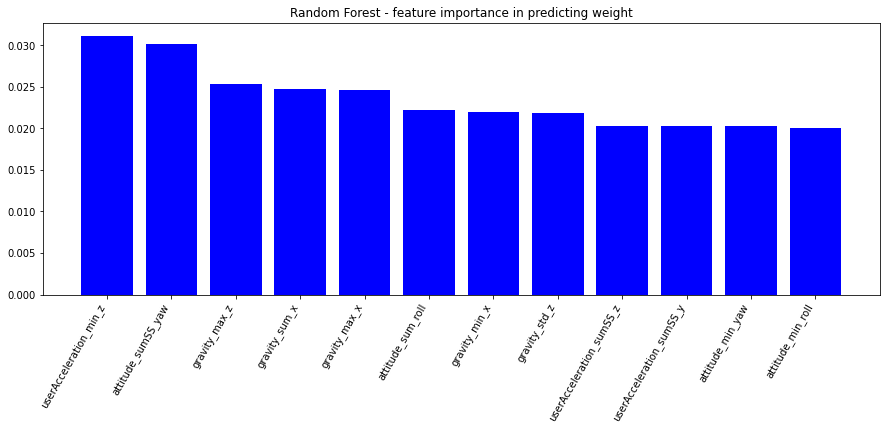

In [ ]:
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - feature importance in predicting weight', top_features=12)

###Age

Mapping - subjects above the average age of 28.79 are labeled as 1; 0 for below average

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':0,
    '7':1,
    '8':0,
    '9':1,
    '10':1,
    '11':0,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':1,
    '17':0,
    '18':0,
    '19':0,
    '20':0,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
#@title
# Create age labels
Y4 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
#@title
y4 = to_categorical(Y4)

X_train, X_test, Y_train, Y_test = train_test_split(X, y4, test_size=0.3, random_state=0)
#print('The number of training samples:',X_train.shape[0])
#print('The number of test samples:',X_test.shape[0])

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
t0=time()
score = model.evaluate(X_test, Y_test)
print('Neural Network (keras) accuracy:', score[1])
print('Multi Layer Perception total_time: {:.2f} sec'.format(time()-t0))

32/32 [==============================] - 0s 1ms/step - loss: 0.6394 - categorical_accuracy: 0.8879
Neural Network (keras) accuracy: 0.8878968358039856
Multi Layer Perception total_time: 0.11 sec


Train and test models

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y4, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




Evaluate model performance

In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.72, f1 score: 0.71, total_time: 0.11 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.72, f1 score: 0.71, total_time: 0.10 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
print('LinearSVM - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'), time()-t0))


LinearSVM - accuracy: 0.63, f1 score: 0.57, total_time: 0.57 sec


In [ ]:
t0=time()
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'), time()-t0))


rbf_SVM - accuracy: 0.69, f1: 0.68, total_time: 0.88 sec


In [ ]:
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.87, f1 score: 0.87, total_time: 0.26 sec


In [ ]:
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.86, f1 score: 0.86, total_time: 0.32 sec


In [ ]:
#@title
t0=time()
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro'), time()-t0))

Random Forest - accuracy: 0.95, f1 score: 0.95, total_time: 25.10 sec


In [ ]:
#@title
print('LinearSVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro')))
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro')))
print('Logistic_regression (L1) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro')))
print('Logistic_regression (L2) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L2.predict(X_test),average ='macro')))
print('Decision tree - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro')))
print('Random Forest - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro')))
print('K- Nearest Neighbour - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro')))


LinearSVM - accuracy: 0.63, f1: 0.57
rbf_SVM - accuracy: 0.69, f1: 0.68
Logistic_regression (L1) - accuracy: 0.72, f1: 0.71
Logistic_regression (L2) - accuracy: 0.72, f1: 0.72
Decision tree - accuracy: 0.86, f1: 0.86
Random Forest - accuracy: 0.95, f1: 0.95
K- Nearest Neighbour - accuracy: 0.87, f1: 0.87


In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Age - Random Forest Confusion Matrix")
    else:
        print('Age - Random Forest Confusion Matrix')

    print(cm)

cnf_matrix = confusion_matrix(Y_test, RF.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Age - Random Forest Confusion Matrix')

Age - Random Forest Confusion Matrix
[[524  27]
 [ 27 430]]


Random Forest accuracy: 0.9474206349206349


<Figure size 432x288 with 0 Axes>

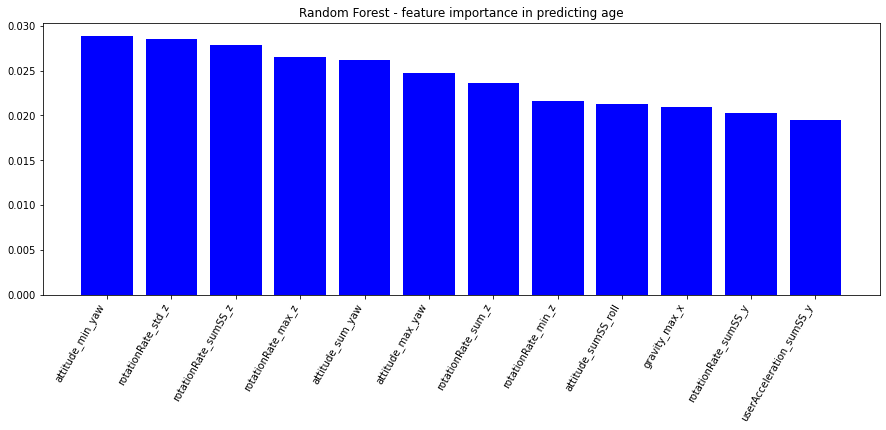

In [ ]:
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - feature importance in predicting age', top_features=12)

###**Height**

Mapping - the trail participants with above average height of 174.2cm are labeled as 1; 0 for below average

In [ ]:
#@title
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':1,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':0,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
#@title
# Create age labels
Y5 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
#@title
y5 = to_categorical(Y5)

X_train, X_test, Y_train, Y_test = train_test_split(X, y5, test_size=0.3, random_state=0)
#print('The number of training samples:',X_train.shape[0])
#print('The number of test samples:',X_test.shape[0])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
t0=time()
score = model.evaluate(X_test, Y_test)
print('Neural Network (keras) accuracy:', score[1])
print('Multi Layer Perception total_time: {:.2f} sec'.format(time()-t0))

32/32 [==============================] - 0s 1ms/step - loss: 0.7830 - categorical_accuracy: 0.8661
Neural Network (keras) accuracy: 0.8660714030265808
Multi Layer Perception total_time: 0.11 sec


Train and test models

In [ ]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y5, test_size=0.3, random_state=0)

LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
t0=time()
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L1) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L1) - accuracy: 0.73, f1 score: 0.73, total_time: 0.15 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
print('Logistic_regression (L2) - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro'), time()-t0))

Logistic_regression (L2) - accuracy: 0.74, f1 score: 0.73, total_time: 0.12 sec


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
t0=time()
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
print('LinearSVM - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'), time()-t0))


LinearSVM - accuracy: 0.62, f1 score: 0.62, total_time: 0.61 sec


In [ ]:
t0=time()
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'), time()-t0))


rbf_SVM - accuracy: 0.71, f1: 0.71, total_time: 0.92 sec


In [ ]:
t0=time()
clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)
print('K- Nearest Neighbour  - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro'), time()-t0))

K- Nearest Neighbour  - accuracy: 0.88, f1 score: 0.88, total_time: 0.26 sec


In [ ]:
t0=time()
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
print('Decision Tree - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro'), time()-t0))

Decision Tree - accuracy: 0.90, f1 score: 0.90, total_time: 0.27 sec


In [ ]:
#@title
t0=time()
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest - accuracy: {:.2f}, f1 score: {:.2f}, total_time: {:.2f} sec'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro'), time()-t0))

Random Forest - accuracy: 0.96, f1 score: 0.96, total_time: 23.85 sec


Random Forest accuracy: 0.9642857142857143


<Figure size 432x288 with 0 Axes>

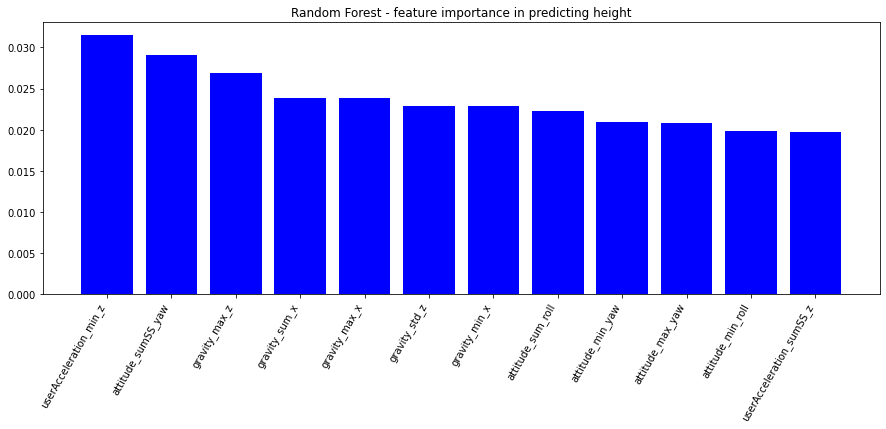

In [ ]:
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - feature importance in predicting height', top_features=12)

Evaluate model performance

In [ ]:
#@title
print('LinearSVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_linear.predict(X_test)),f1_score(Y_test,SVM_linear.predict(X_test),average ='macro')))
print('rbf_SVM - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, SVM_rbf.predict(X_test)),f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro')))
print('Logistic_regression (L1) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L1.predict(X_test)),f1_score(Y_test,LR_L1.predict(X_test),average ='macro')))
print('Logistic_regression (L2) - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, LR_L2.predict(X_test)),f1_score(Y_test,LR_L2.predict(X_test),average ='macro')))
print('Decision tree - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, DT.predict(X_test)),f1_score(Y_test,DT.predict(X_test),average ='macro')))
print('Random Forest - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, RF.predict(X_test)),f1_score(Y_test,RF.predict(X_test),average ='macro')))
print('K- Nearest Neighbour - accuracy: {:.2f}, f1: {:.2f}'.format(accuracy_score(Y_test, KNN.predict(X_test)),f1_score(Y_test,KNN.predict(X_test),average ='macro')))

LinearSVM - accuracy: 0.62, f1: 0.62
rbf_SVM - accuracy: 0.71, f1: 0.71
Logistic_regression (L1) - accuracy: 0.73, f1: 0.73
Logistic_regression (L2) - accuracy: 0.74, f1: 0.73
Decision tree - accuracy: 0.90, f1: 0.90
Random Forest - accuracy: 0.96, f1: 0.96
K- Nearest Neighbour - accuracy: 0.88, f1: 0.88


In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Height - Random Forest Confusion Matrix")
    else:
        print('Height - Random Forest Confusion Matrix')

    print(cm)

cnf_matrix = confusion_matrix(Y_test, RF.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Height - Random Forest Confusion Matrix')

Height - Random Forest Confusion Matrix
[[451  14]
 [ 22 521]]


###Summary

Performance of the models varied significantly with the Random Forest Classifier having the highest accuracy for each variable. Models ranged in accuracy of predicting gender 70% to 97%, height 62% to 96%, age 63% to 94% and weight from 61% to 96% accuracy. 

Confusion matrices showed that the Random Tree models for gender, weight and height had a higher number of false positives and age a higher number of false negatives. The false positives incorrectly predicted that gender was male or weight and height were above average. The false negative incorrectly predicted an age lower than the average.